In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cats = ['Movie ID', 'Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = np.genfromtxt('data/movies.txt', delimiter='\t', dtype=None, encoding='utf-8', names=cats, deletechars='')
data = np.loadtxt('data/data.txt').astype(int)

In [3]:
# Movie data needs to be processed to remove years in parentheses
# This will make visualizations cleaner later on
parse_titles = []
years = []
for i in range(len(movies['Title'])): 
    title = movies['Title'][i].replace('"', '')
    j = title.find("(19")
    parse_titles.append(title[0:j].strip())
    years.append(title[j+1:j+5])

# Part 4: Basic Visualizations
**4.1**: All ratings in the MovieLens Dataset

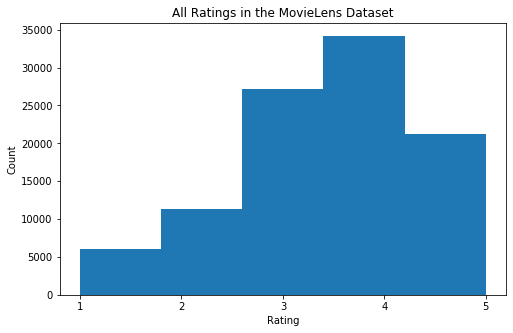

In [4]:
plt.figure(figsize=(8,5))
plt.hist(data[:,2], bins=5);
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('All Ratings in the MovieLens Dataset');

**4.2**: All ratings of the ten most popular movies

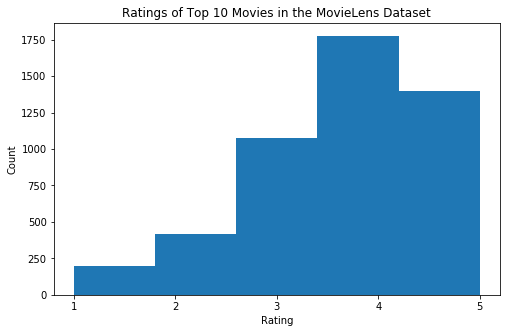

In [5]:
# get index of top 10 movies with most ratings
top10 = np.argpartition(np.bincount(data[:,1]), -10)[-10:]
# get indices of data corresponding to these movies
top10_data = np.nonzero(np.isin(data[:,1], top10))
# get the data itself
top10ratings = data[top10_data,:][0]
# plot the data in a histogram
plt.figure(figsize=(8,5))
plt.hist(top10ratings[:,2], bins=5);
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Ratings of Top 10 Movies in the MovieLens Dataset');

**4.3**: All ratings of the ten best movies

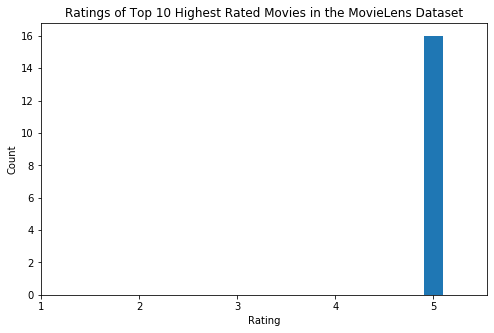

In [51]:
# get average ratings for the movies
avg_ratings = []
for j in range(len(movies['Title'])):
    avg_ratings.append(np.mean(data[np.where(data[:,1] == j + 1), 2]))
    
# get index of movies with top 10 ratings
top10ratings = np.argpartition(np.asarray(avg_ratings),-10)[-10:]+1
# get indices of data corresponding to these movies
top10ratings_data = np.nonzero(np.isin(data[:,1], top10ratings))
# get the data itself
ratings_data = data[top10ratings_data,:][0]
# plot the data in a histogram
plt.figure(figsize=(8,5))
plt.hist(ratings_data[:,2], bins=5);
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Ratings of Top 10 Highest Rated Movies in the MovieLens Dataset');

**4.4**: All ratings from Action, Adventure and Animation

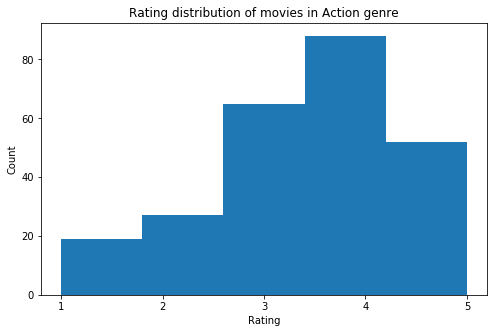

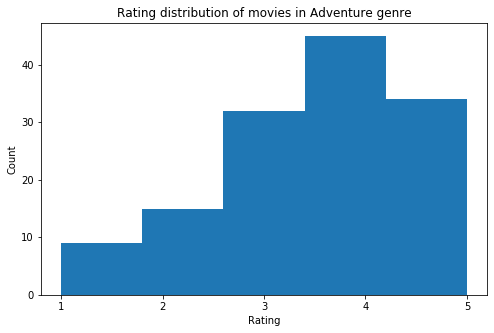

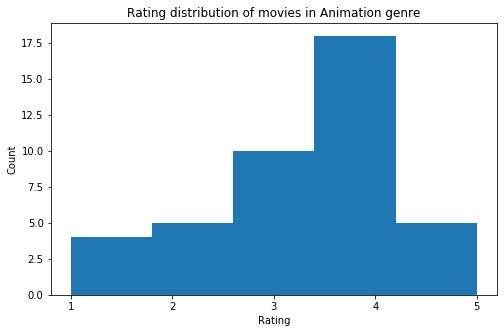

In [7]:
genres = ['Action','Adventure','Animation']
for genre in genres:
    genre_data = np.array(np.where(movies[genre] == 1))[0]
    plt.subplots(figsize=(8,5))
    plt.hist(data[genre_data,2], bins=5)
    plt.xticks(np.arange(1,6));
    plt.xlabel('Rating');
    plt.ylabel('Count');
    plt.title('Rating distribution of movies in {} genre'.format(genre));

# Part 5: Matrix Factorization
**5.1**: Using code from HW5. 

In [8]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    return eta *(reg * Ui - Vj * (Yij - np.dot(np.transpose(Ui), Vj)))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta *(reg * Vj - Ui * (Yij - np.dot(np.transpose(Ui), Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    k = 0

    U_norm_squared = np.linalg.norm(U, 'fro') ** 2
    V_norm_squared = np.linalg.norm(V, 'fro') ** 2
    
    
    sum_err = 0
    for tup in Y:
        i, j = tup[0] - 1, tup[1] - 1
        Y_ij = tup[2]

        sum_err += (Y_ij - np.dot(np.transpose(U[i]), V[j])) ** 2
            
    return (reg/2 * (U_norm_squared + V_norm_squared) + 1/2 * sum_err)/len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    eta = 0.03

    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    
    prev_err = get_err(U, V, Y, reg=reg)
    first_loss = 0
    indices = np.arange(len(Y))
    for epoch in range(max_epochs):
        np.random.shuffle(indices)
        
        for k in indices:
            tup = Y[k]
            
            i, j = tup[0] - 1, tup[1] - 1
            Y_ij = tup[2]
            
            U[i] = U[i] - grad_U(U[i], Y_ij, V[j], reg, eta)
            V[j] = V[j] - grad_V(V[j], Y_ij, U[i], reg, eta)
        
        if epoch == 0:
            first_loss = get_err(U, V, Y, reg=reg) - prev_err
            
        new_err = get_err(U, V, Y, reg=reg)
        if (new_err - prev_err)/first_loss < eps:
            break
        
        prev_err = new_err
        
    return (U, V, get_err(U, V, Y, reg=0))

In [9]:
train = np.loadtxt('data/train.txt').astype(int)
test = np.loadtxt('data/test.txt').astype(int)

M = max(max(train[:,0]), max(test[:,0])).astype(int) 
N = movies.shape[0] 

print('Matrix Factorization with model from HW5')

reg = 0.1
eta = 0.01 
k = 20

print("Training model with k = {}, eta = {}, reg = {}".format(k, eta, reg))
U, V, err = train_model(M, N, k, eta, reg, train)
E_out = get_err(U, V, test)
V = V.T 
print("Test error: " + str(E_out))
print('Done!')

Matrix Factorization with model from HW5
Training model with k = 20, eta = 0.01, reg = 0.1
Test error: 0.44767630325545826
Done!


In [10]:
# rescale dimensions and perform SVD
V_centered = V - np.tile(np.resize(np.mean(V, axis=1), (k, 1)),(1, V.shape[1]))
A, S, B = np.linalg.svd(V_centered, full_matrices=False)
V_ = np.dot(A[:,0:2].T, V_centered)

# Normalize data
V_[0] = (V_[0] - np.mean(V_[0])) / np.std(V_[0])
V_[1] = (V_[1] - np.mean(V_[1])) / np.std(V_[1])

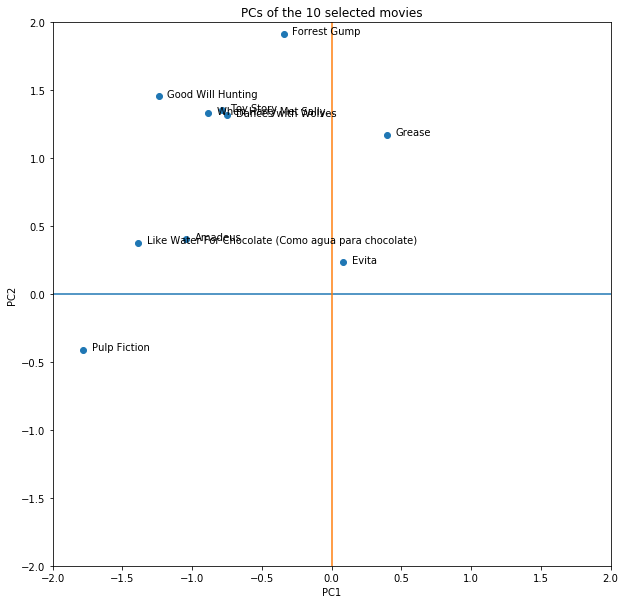

In [11]:
titles10 = ['Forrest Gump', 'Good Will Hunting', "Toy Story",
                'Amadeus', 'Dances with Wolves', 'Evita', 'Grease',
                'Like Water For Chocolate (Como agua para chocolate)', 'Pulp Fiction', 'When Harry Met Sally...']
i = np.nonzero(np.isin(parse_titles, titles10))[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.title('PCs of the 10 selected movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-2, 2])
plt.xlim([-2, 2])
plt.plot([-2, 2], [0, 0])
plt.plot([0, 0], [-2, 2])
ax.scatter(V_[0,i],V_[1,i])

# Label movies
for j in i:
    ax.annotate(parse_titles[j], (V_[0, j] + 0.01 * 6, V_[1, j] - 0.001 * 6), fontsize=10)

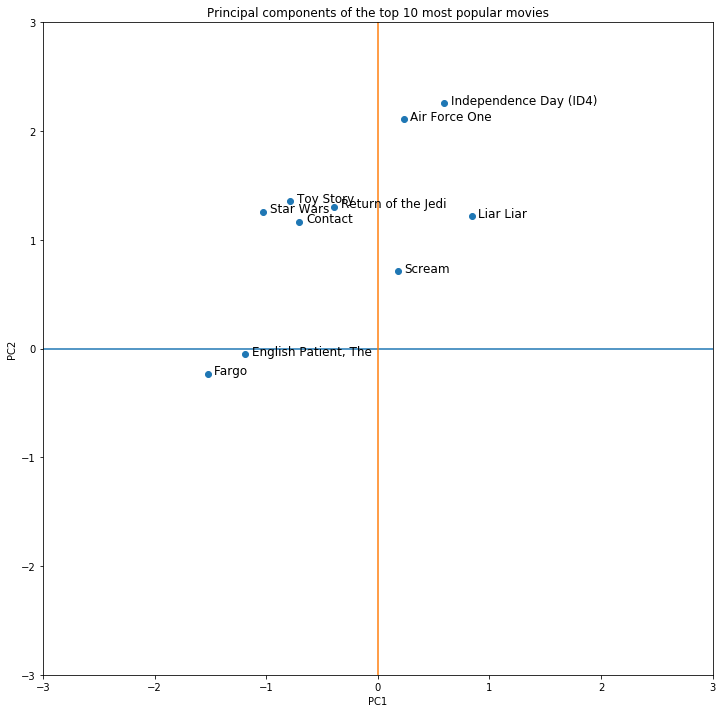

In [12]:
movies10 = np.bincount(data[:,1])[1:]
i = (np.argpartition(movies10,-10)[-10:])[:10]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(V_[0,i],V_[1,i])
plt.title('Principal components of the top 10 most popular movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.plot([-3, 3], [0, 0])
plt.plot([0, 0], [-3, 3])

## Label movies
for j in i:
    ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=12)

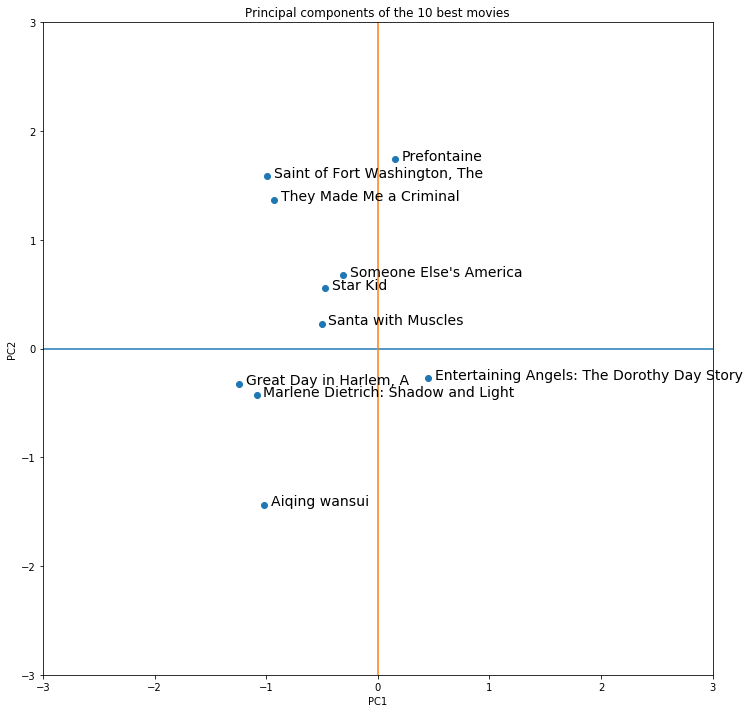

In [13]:
bestmovies = np.zeros(1682) 
for j in np.arange(len(movies['Title'])):
    bestmovies[j] = np.mean(data[np.where(data[:,1]==j+1),2])
i = np.argpartition(bestmovies, -10)[-10:]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(V_[0,i],V_[1,i])
plt.title('Principal components of the 10 best movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.plot([-3, 3], [0, 0])
plt.plot([0, 0], [-3, 3])


## Label movies
for j in i:
    ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=14)

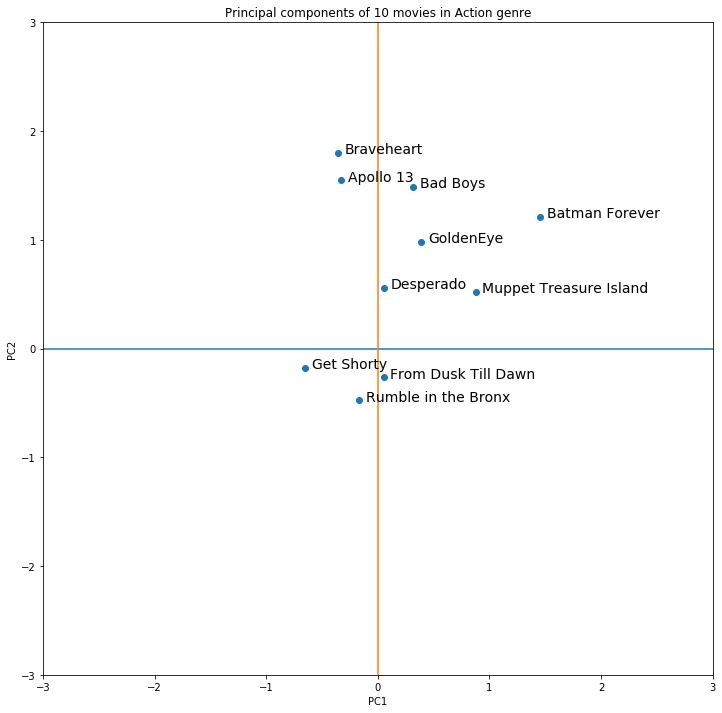

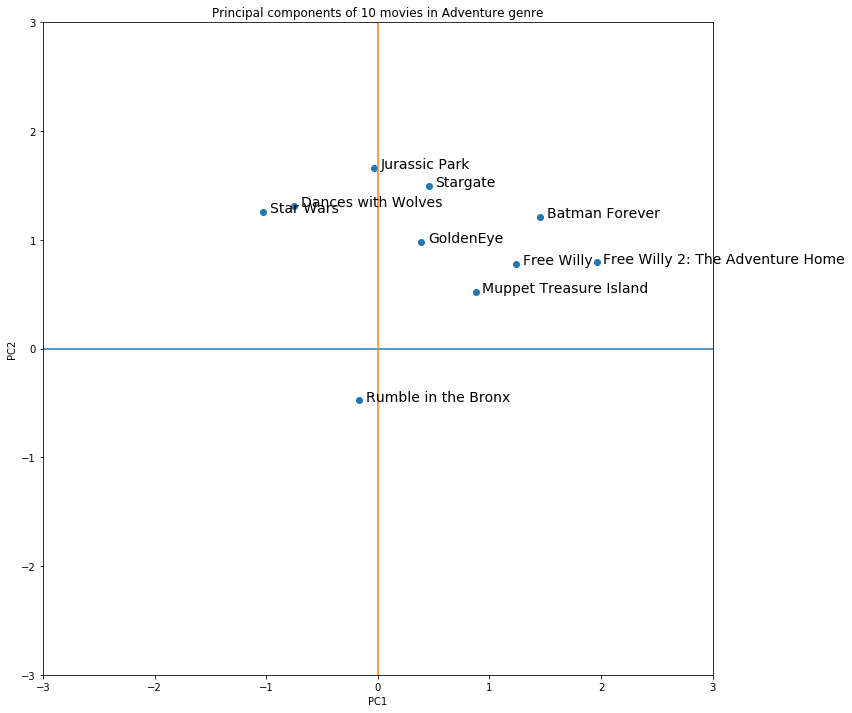

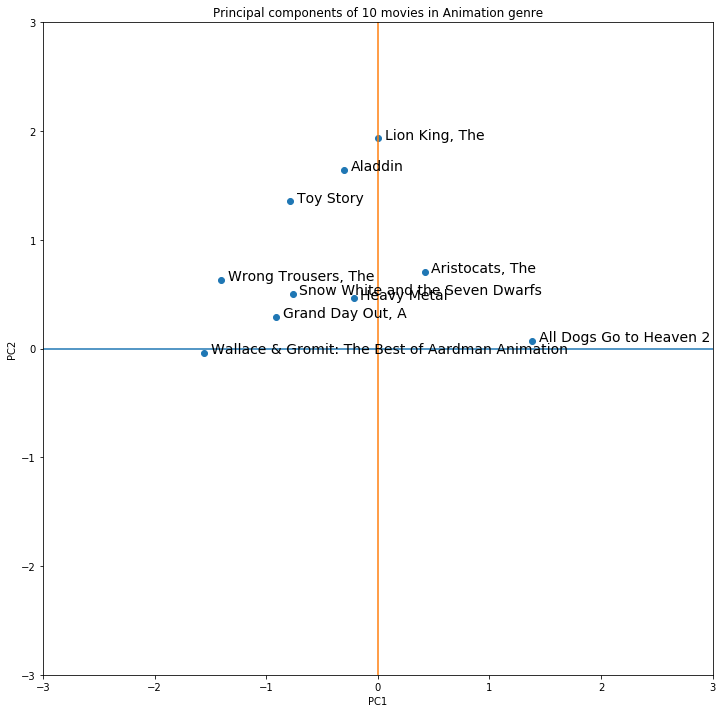

In [14]:
genres = ['Action','Adventure','Animation']

for idx,val in enumerate(genres):
    i = (np.array(np.where(movies[val]==1))[0])[:10]

    fig,ax = plt.subplots(figsize=(12,12))
    ax.scatter(V_[0,i],V_[1,i])
    
    plt.title('Principal components of 10 movies in {} genre'.format(val));
    plt.xlabel('PC1');
    plt.ylabel('PC2');
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.plot([-3, 3], [0, 0])
    plt.plot([0, 0], [-3, 3])

    ## Label movies
    for j in i:
        ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=14)

5.2 Matrix Factorization with Bias

In [26]:
def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    return eta * (reg * Ui - Vj * ((Yij - mu) - (np.dot(np.transpose(Ui), Vj)) + ai + bj))

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * ((Yij - mu) - (np.dot(np.transpose(Ui), Vj)) + ai + bj))

def grad_a(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    return eta * (reg * ai - ((Yij - mu) - (np.dot(np.transpose(Ui), Vj) + ai + bj)))
    
def grad_b(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    return eta * (reg * bj - ((Yij - mu) - (np.dot(np.transpose(Ui), Vj) + ai + bj)))

def get_err(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    k = 0
    mu = np.mean(Y[:, 2])
    
    U_norm_squared = np.linalg.norm(U, 'fro') ** 2
    V_norm_squared = np.linalg.norm(V, 'fro') ** 2
    a_norm_squared = np.linalg.norm(a) ** 2
    b_norm_squared = np.linalg.norm(b) ** 2
    
    sum_err = 0
    for tup in Y:
        i, j = tup[0] - 1, tup[1] - 1
        Y_ij = tup[2]

        sum_err += ((Y_ij - mu) - (np.dot(np.transpose(U[i]), V[j]) + a[i] + b[j])) ** 2
            
    return (reg/2 * (U_norm_squared + V_norm_squared + a_norm_squared + b_norm_squared) + 1/2 * sum_err)/len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    print("Matrix training with biased model")
    eta = 0.03
    
    mu = np.mean(Y[:, 2])

    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    
    a = np.random.uniform(-0.5, 0.5, (M, 1))
    b = np.random.uniform(-0.5, 0.5, (N, 1))
    
    prev_err = get_err(U, V, Y, a, b, reg=reg)
    first_loss = 0
    indices = np.arange(len(Y))
    for epoch in range(max_epochs):
        np.random.shuffle(indices)
        
        for k in indices:
            tup = Y[k]
            
            i, j = tup[0] - 1, tup[1] - 1
            Y_ij = tup[2]
            
            U[i] = U[i] - grad_U(U[i], Y_ij, V[j], a[i], b[j], mu, reg, eta)
            V[j] = V[j] - grad_V(V[j], Y_ij, U[i], a[i], b[j], mu, reg, eta)
        
            a[i] = a[i] - grad_a(U[i], Y_ij, V[j], a[i], b[j], mu, reg, eta)
            b[j] = b[j] - grad_b(U[i], Y_ij, V[j], a[i], b[j], mu, reg, eta)
        
        if epoch == 0:
            first_loss = get_err(U, V, Y, a, b, reg=reg) - prev_err
            
        new_err = get_err(U, V, Y, a, b, reg=reg)
        if (new_err - prev_err)/first_loss < eps:
            break
        
        prev_err = new_err
        
    return (U, V, a, b, get_err(U, V, Y, a, b, reg=0))

In [27]:
train = np.loadtxt('data/train.txt').astype(int)
test = np.loadtxt('data/test.txt').astype(int)

M = max(max(train[:,0]), max(test[:,0])).astype(int) 
N = movies.shape[0] 

print('Matrix Factorization with model from HW5')

reg = 0.1
eta = 0.01 
k = 20

print("Training model with k = {}, eta = {}, reg = {}".format(k, eta, reg))
U, V, a, b, err = train_model(M, N, k, eta, reg, train)
E_out = get_err(U, V, test, a, b)
V = V.T 
print("Test error: " + str(E_out))
print('Done!')

Matrix Factorization with model from HW5
Training model with k = 20, eta = 0.01, reg = 0.1
Matrix training with biased model
Test error: [0.43052815]
Done!


In [53]:
# rescale dimensions and perform SVD
V_centered = V - np.tile(np.resize(np.mean(V, axis=1), (k, 1)),(1, V.shape[1]))
A, S, B = np.linalg.svd(V_centered, full_matrices=False)
V_ = np.dot(A[:,0:2].T, V_centered)

# Normalize data
V_[0] = (V_[0] - np.mean(V_[0])) / np.std(V_[0])
V_[1] = (V_[1] - np.mean(V_[1])) / np.std(V_[1])

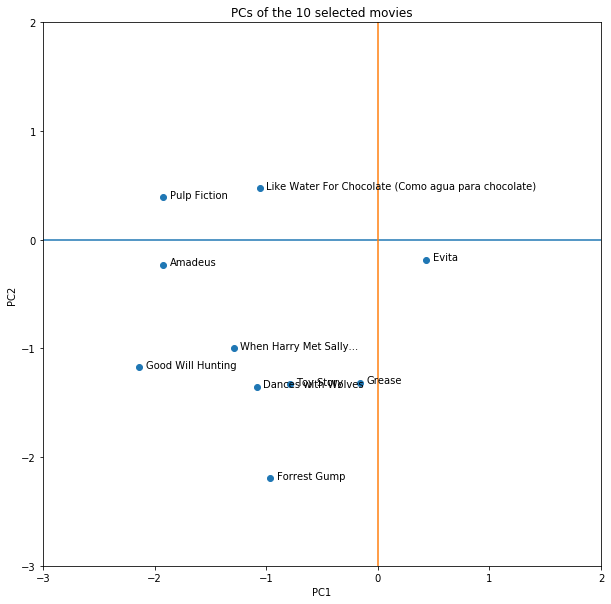

In [55]:
titles10 = ['Forrest Gump', 'Good Will Hunting', "Toy Story",
                'Amadeus', 'Dances with Wolves', 'Evita', 'Grease',
                'Like Water For Chocolate (Como agua para chocolate)', 'Pulp Fiction', 'When Harry Met Sally...']
i = np.nonzero(np.isin(parse_titles, titles10))[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.title('PCs of the 10 selected movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 2])
plt.xlim([-3, 2])
plt.plot([-3, 2], [0, 0])
plt.plot([0, 0], [-3, 2])
ax.scatter(V_[0,i],V_[1,i])

# Label movies
for j in i:
    ax.annotate(parse_titles[j], (V_[0, j] + 0.01 * 6, V_[1, j] - 0.001 * 6), fontsize=10)

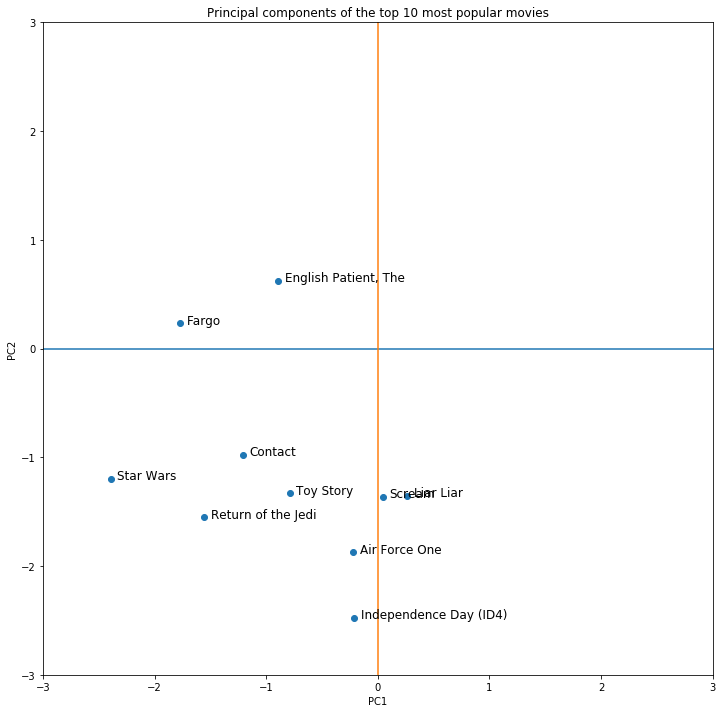

In [56]:
movies10 = np.bincount(data[:,1])[1:]
i = (np.argpartition(movies10,-10)[-10:])[:10]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(V_[0,i],V_[1,i])
plt.title('Principal components of the top 10 most popular movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.plot([-3, 3], [0, 0])
plt.plot([0, 0], [-3, 3])

## Label movies
for j in i:
    ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=12)

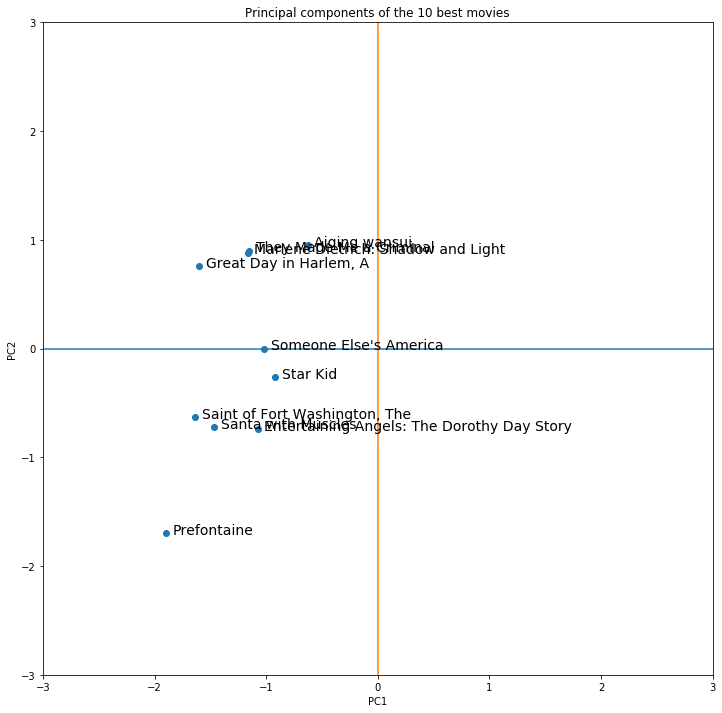

In [57]:
bestmovies = np.zeros(1682) 
for j in np.arange(len(movies['Title'])):
    bestmovies[j] = np.mean(data[np.where(data[:,1]==j+1),2])
i = np.argpartition(bestmovies, -10)[-10:]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(V_[0,i],V_[1,i])
plt.title('Principal components of the 10 best movies');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.plot([-3, 3], [0, 0])
plt.plot([0, 0], [-3, 3])


## Label movies
for j in i:
    ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=14)

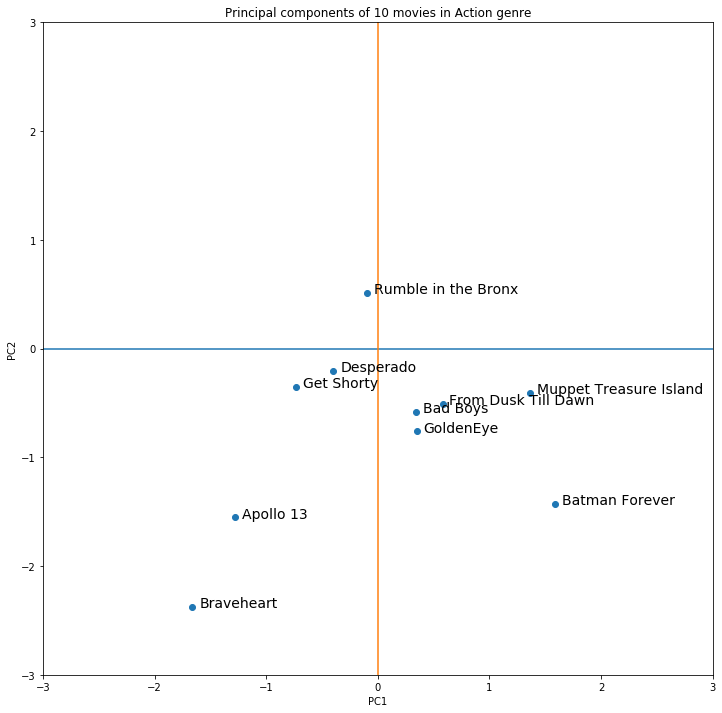

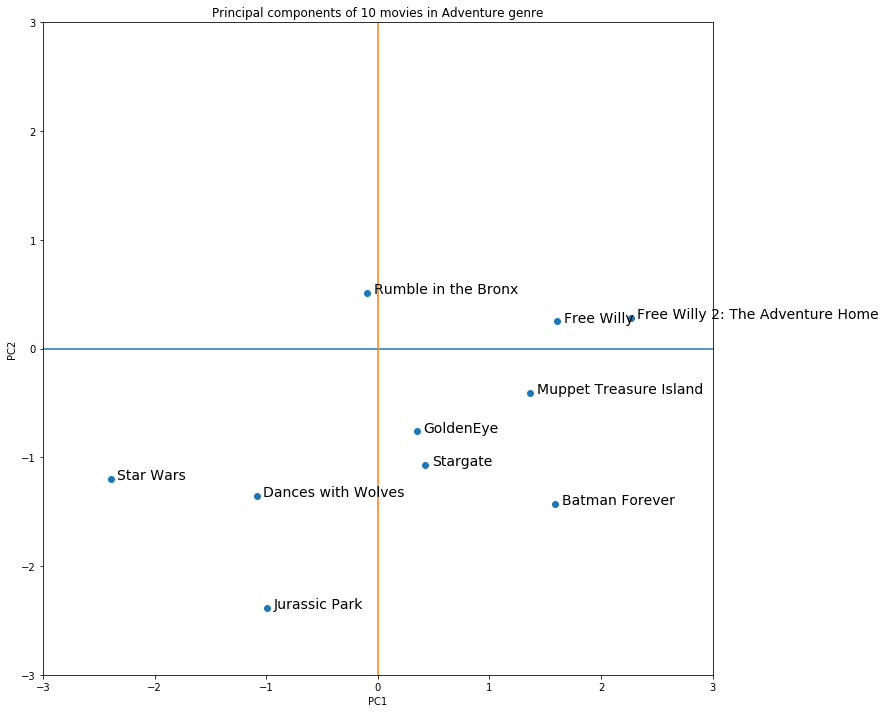

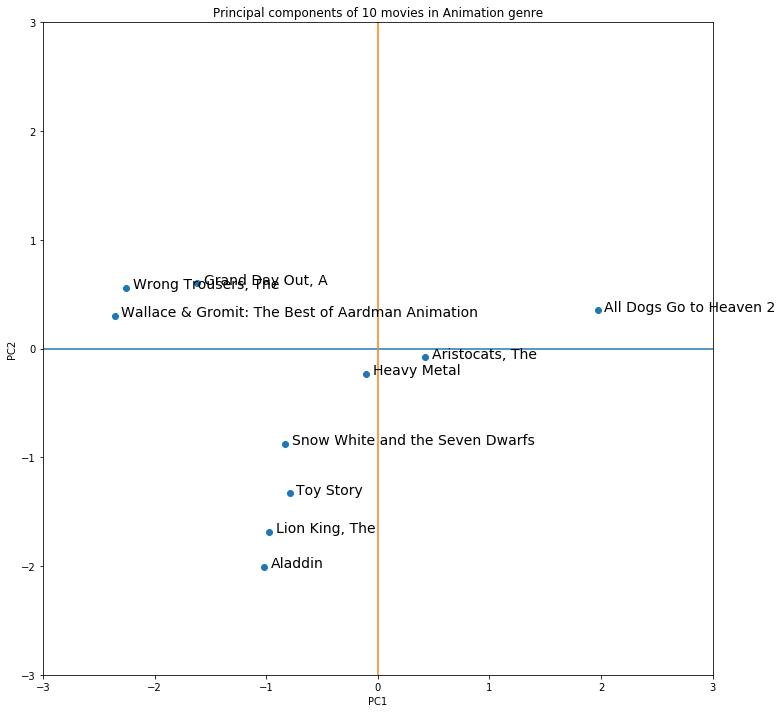

In [58]:
genres = ['Action','Adventure','Animation']

for idx,val in enumerate(genres):
    i = (np.array(np.where(movies[val]==1))[0])[:10]

    fig,ax = plt.subplots(figsize=(12,12))
    ax.scatter(V_[0,i],V_[1,i])
    
    plt.title('Principal components of 10 movies in {} genre'.format(val));
    plt.xlabel('PC1');
    plt.ylabel('PC2');
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.plot([-3, 3], [0, 0])
    plt.plot([0, 0], [-3, 3])

    ## Label movies
    for j in i:
        ax.annotate(parse_titles[j],(V_[0,j]+0.01*6,V_[1,j]-0.001*6),fontsize=14)

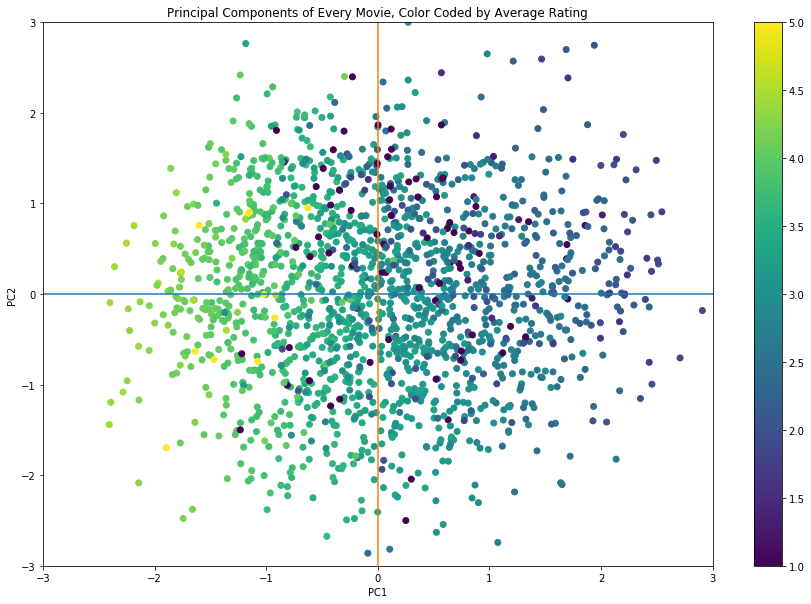

In [59]:
plt.figure(figsize=(15,10))
plt.scatter(V_[0], V_[1], c=avg_ratings)
plt.title('Principal Components of Every Movie, Color Coded by Average Rating');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.plot([-3, 3], [0, 0])
plt.plot([0, 0], [-3, 3])
plt.colorbar()



5.3 SurpriseSVD Implementation

In [61]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF

reader = Reader(line_format='user item rating', sep='\t')
train = Dataset.load_from_file('data/train.txt', reader=reader)
test = Dataset.load_from_file('data/test.txt', reader=reader)
model = NMF(n_factors=20)
model.fit(train.build_full_trainset())
predictions = model.test(test.build_full_trainset().build_testset())
err_test = accuracy.rmse(predictions)**2
V = model.qi
print('Test error: %f' % err_test)

RMSE: 0.9606
Test error: 0.922806
